# Mercury's relativistic precession

One of the early successes of [general relativity](https://en.wikipedia.org/wiki/General_relativity) (GR) was the explanation of an [excess in the precession of Mercury's perihelion](https://en.wikipedia.org/wiki/Mercury_(planet)#Advance_of_perihelion) that could not be accounted for via Newtonian gravity. In this tutorial
we will show how we can reproduce this classical result with heyoka.py.

In the weak gravitational field regime, the formulation of GR can be greatly simplified via the formalism of [post-Newtonian approximations](https://en.wikipedia.org/wiki/Post-Newtonian_expansion) (PN). In the specific case of Mercury's relativistic perihelion precession, a first-order post-Newtonian expansion of the full GR equations is sufficient. The 1PN Hamiltonian of a test particle orbiting a spherical mass reads, in Cartesian coordinates:

$$
\mathcal{H}_\mathrm{1PN} \left(v_x, v_y, v_z, x, y, z \right) = \frac{1}{2}v^2-\frac{\mu}{r} + \varepsilon \left(\frac{\mu^2}{2r^2} -\frac{1}{8}v^4-\frac{3}{2}\frac{\mu v^2}{r} \right),
$$

where $\varepsilon = 1/c^2$, $v=\sqrt{v_x^2+v_y^2+v_z^2}$, $r=\sqrt{x^2+y^2+z^2}$ and $\mu=GM$ is the gravitational parameter of the system. In other words, $\mathcal{H}_\mathrm{1PN}$ is a Keplerian one-body Hamiltonian augmented by a velocity-dependent perturbation of magnitude $\varepsilon$.

Let us write down the Hamiltonian using heyoka.py's expression system:

In [1]:
import heyoka as hy

# Create the symbolic variables.
vx, vy, vz, x, y, z = hy.make_vars("vx", "vy", "vz", "x", "y", "z")

# mu and eps constants.
mu = 0.01720209895 * 0.01720209895 * 365 * 365
eps = 2.5037803127808595e-10

# Auxiliary quantities.
v2 = vx * vx + vy * vy + vz * vz
r2 = x * x + y * y + z * z
r = hy.sqrt(r2)

# Define the Hamiltonian.
Ham = (
    1.0 / 2 * v2
    - mu / r
    + eps * (mu**2 / (2 * r2) - 1 / 8.0 * v2 * v2 - 3.0 / 2.0 * mu * v2 / r)
)

As usual, we are using Solar masses, astronomical units and years as units of measure.

Let us now define the initial conditions for Mercury's orbit. Semi-major axis, eccentricity and inclination are those of Mercury's current orbit. The initial argument of perihelion $\omega_0$ is set to a value of 1:

In [2]:
import pykep as pk
import numpy as np

# Mercury's initial position and velocity.
r0, v0 = pk.par2ic([0.387098, 0.205630, 7 * 2 * np.pi / 360, 0.0, 1.0, 0.0], mu)

We can now proceed to the creation of the integrator object. We will be using the {func}`~heyoka.hamiltonian()` function to automatically generate the equations of motion from the Hamiltonian:

In [3]:
ta = hy.taylor_adaptive(
    # Hamilton's equations.
    hy.hamiltonian(Ham, [x, y, z], [vx, vy, vz]),
    # Initial conditions.
    r0 + v0,
)

Let us now numerically integrate for 100 years:

In [4]:
tgrid = np.linspace(0, 100, 1000)

_, _, _, _, _, out = ta.propagate_grid(tgrid)

We can now convert the result of the numerical integration to Keplerian orbital elements:

In [5]:
kep_out = np.array([pk.ic2par(_[0:3], _[3:], mu=mu) for _ in out])

We are now ready to visualise the results. GR predicts for Mercury a relativistic precession of $42.98^{\prime\prime}$ per century, or roughly $2.08373\times 10^{-4}\,\mathrm{rad}$ per century. Let us then plot the time evolution of the argument of perihelion and compare it to the theoretical prediction:

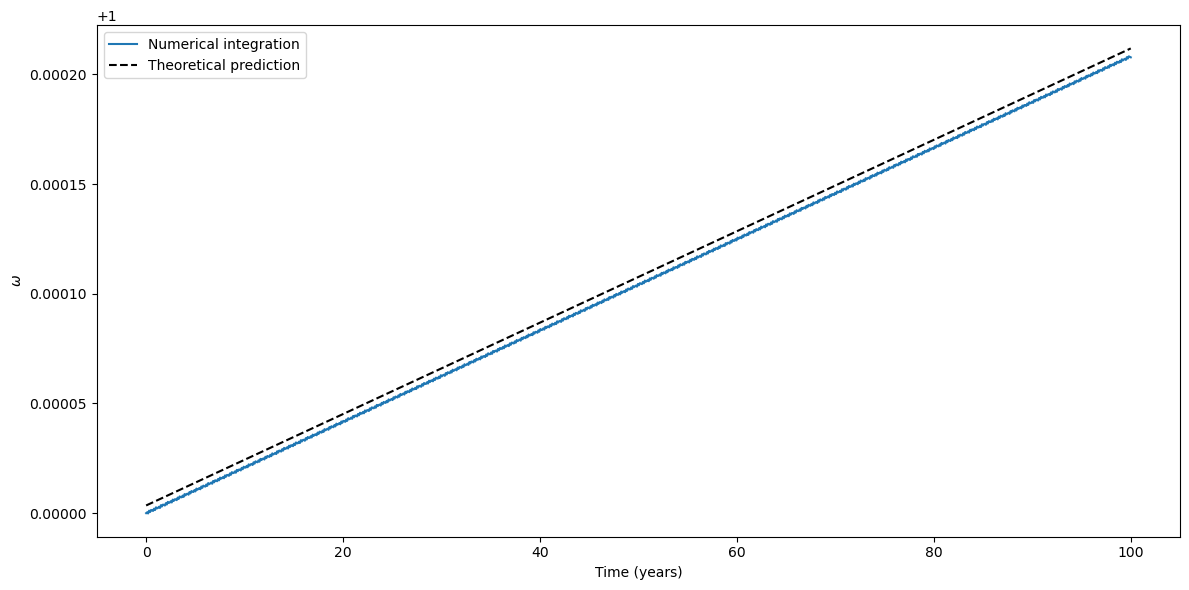

In [6]:
%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize=(12, 6))

plt.plot(tgrid, kep_out[:, 4], label="Numerical integration")
# NOTE: offset slightly the line for the theoretical
# prediction in order to improve the readability.
plt.plot(
    tgrid, 1.0000035 + 2.08373e-4 * tgrid / 100.0, "k--", label="Theoretical prediction"
)

plt.xlabel("Time (years)")
plt.ylabel(r"$\omega$")

plt.legend()
plt.tight_layout()

Note that we added a slight offset to the theoretical prediction, because otherwise the two lines would have been overlapping, resulting in an unreadable graph.

We can see how the numerically-computed precession matches very well the theoretical prediction. Note also how, in addition to the long-term linear behaviour, the numerical integration also highlights small short-term periodic oscillations which are also due to relativistic effects.